# Libraries

In [25]:
#pip install pydicom
#pip install dicom_mask
#pip install pyelastix
#pip install SimpleITK
#pip install elasticdeform
#pip install SimpleITK-SimpleElastix

import os
import pandas as pd

from scipy.sparse import csc_matrix
import scipy.ndimage as scn

import pydicom
from pydicom import dcmread
#from dicom_mask.convert import struct_to_mask

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm

import numpy as np
from PIL import Image
import scipy
import scipy.io
import scipy.ndimage
from scipy.spatial.distance import directed_hausdorff

from ipywidgets.widgets import * 
import ipywidgets as widgets

from sklearn.metrics import jaccard_score


from ipywidgets.widgets import * 
import ipywidgets as widgets

from skimage import metrics

from sklearn.metrics import jaccard_score


import SimpleITK as sitk
import sys


from ipywidgets import interact

import random
import gc
############
import sys
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from matplotlib.pyplot import figure
import numpy as np
import seaborn as sns
import scipy
import scipy.io
import scipy.ndimage
from scipy.spatial.distance import directed_hausdorff
import scipy.ndimage
import random
import gc
from skimage import metrics
from skimage import measure
from sklearn.metrics import jaccard_score
from sklearn.metrics import mean_absolute_error as mae
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv3D, MaxPool2D, MaxPool3D, Flatten, Dropout, GlobalMaxPooling3D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import h5py

### _Reading the CT_TH DICOM files_ (Ground truth)

#### > CT images

In [3]:
directory = 'CT_TH/CT/'
path =  sorted(os.listdir(directory))
ct_dir = [file for file in path if file.startswith("2")]    #---->>> To avoid any other file
ct = [pydicom.dcmread(directory+ct_dir[i]) for i in range (len(ct_dir))]
ct = sorted(ct, key=lambda x: x.ImagePositionPatient[2])    #----->>> To order the CT slices
ct_i = np.array([ct[i].pixel_array for i in range (len(ct))])
ct = np.array([ct_i[i]/ct_i[103].max() for i in range (len(ct))])
#np.save('model_dataset/ct_TH.npy', ct)

#### > Structures

In [29]:
ct = [pydicom.dcmread(directory+ct_dir[i]) for i in range (len(ct_dir))]
ct = sorted(ct, key=lambda x: x.ImagePositionPatient[2])
uids = [ct[i].SOPInstanceUID for i in range (len(ct))]
pixels = np.array([(float(ct[i].PixelSpacing[0]), float(ct[i].PixelSpacing[1]))  for i in range(len(ct))])
origins = np.array([ct[i].ImagePositionPatient for i in range(len(ct))]) 

img_array = np.zeros((len(ct), *ct[0].pixel_array.shape) , dtype=np.int16) 
mask_array = np.zeros_like(img_array, dtype=np.int8)
directory = 'CT_TH/RT_S/'
path =  sorted(os.listdir(directory))
rst = [file for file in path if file.startswith("2")]
rs = pydicom.dcmread(directory+'/'+rst[0])
structures= [rs.StructureSetROISequence[i].ROIName for i in range(len(rs.ROIContourSequence))]
print("Structures--->>>", structures)

Structures--->>> ['spinal_canal']


In [23]:
uids[0] #---->>> the contour order was guided matching the unique identifiers per slice

'2.16.840.1.114362.1.12177026.22560474975.657336273.1041.131'

In [30]:
roi_seq_names = list([i.ROIName for i in list(rs.StructureSetROISequence)])
structure_names = roi_seq_names
dummy = ['Spinal Canal']
structures = [dummy[i] if dummy[i] in structure_names else None for i in range(len(dummy))] #---->>> To verify the esistence of the contour
structure_names = list([i.ROIName for i in list(rs.StructureSetROISequence)])
structure_id = structure_names
rtv = rs.ROIContourSequence[0]      #---->>> [0] for 'Spinal Canal'
contours = [contour for contour in rtv.ContourSequence]

In [32]:
for c in contours:
    refd_UID = c.ContourImageSequence[0].ReferencedSOPInstanceUID
    loc_index = uids.index(refd_UID)                 
    x_pixel, y_pixel = pixels[loc_index]              
    x_origin, y_origin, _ = origins[loc_index]       
    contour_coord = c.ContourData

    # x, y, z coordinates of the contour in mm
    x0 = contour_coord[len(contour_coord)-3]
    y0 = contour_coord[len(contour_coord)-2]
    z0 = contour_coord[len(contour_coord)-1]
    coord = []
    for i in range(0, len(contour_coord), 3):
        x = contour_coord[i]
        y = contour_coord[i+1]
        z = contour_coord[i+2]
        l = np.sqrt((x-x0)*(x-x0) + (y-y0)*(y-y0) + (z-z0)*(z-z0))
        l = np.ceil(l*2)+1
        for j in np.arange(1, l+1):
            coord.append([(x-x0)*j/l+x0, (y-y0)*j/l+y0, (z-z0)*j/l+z0])
        x0 = x
        y0 = y
        z0 = z

    # y, x is how it's mapped
    pixel_coords = [(np.round((y - y_origin) / y_pixel), np.round((x - x_origin) / x_pixel)) for x, y, _ in coord]

    rows = []
    cols = []
    for i,j in list(set(pixel_coords)):
        rows.append(i)
        cols.append(j)
    contour_arr = csc_matrix((np.ones_like(rows), (rows, cols)), dtype=np.int8, shape=(img_array[0].shape[0], img_array[0].shape[1])).toarray()
    filled_arr = scn.binary_fill_holes(contour_arr)
    mask_array[loc_index,...] += filled_arr
mask_array[mask_array > 100] = 0
print(mask_array.shape)
spinal_cord = mask_array
#np.save('model_dataset/mask_ct_TH.npy', spinal_cord)

### _Loading CT_TH dataset_

In [36]:
ct1 = np.load('model_dataset/ct_th.npy')
spinal_cord1= np.load('model_dataset/mask_ct_th.npy')
mask= np.array(spinal_cord1, dtype=bool)

In [37]:
def dicom_animation(x):
    figure(figsize=(4, 4))
    #plt.imshow(mask[x,:,:], cmap='inferno_r')
    plt.contour(mask[x,:,:], linewidths=1.5, cmap='winter_r' )
    #plt.colorbar()
    plt.imshow(ct1[x,:,:], alpha=1, aspect='auto', cmap='gray')
    #plt.colorbar()
    #plt.imshow(abs(ct[x]-cbct_1[x]), alpha=0.5, cmap='jet')
    #plt.ylim(350,60)
    #plt.contour(liver[0][x,:,:], cmap='Greens', alpha=0.8)
    #return x

interact(dicom_animation, x=(0, (ct1.shape[0]-1)));

interactive(children=(IntSlider(value=75, description='x', max=151), Output()), _dom_classes=('widget-interact…

In [38]:
def dicom_animation(x):
    figure(figsize=(4, 4))
    plt.contour(mask[:,:,x], linewidths=1.5, cmap='winter_r')
    #plt.colorbar()
    plt.imshow(ct[:,:,x], alpha=1, aspect='auto', cmap='gray')
    #plt.colorbar()
    #plt.imshow(abs(ct[x]-cbct_1[x]), alpha=0.5, cmap='jet')
    plt.ylim(0,152)
    #plt.contour(liver[0][x,:,:], cmap='Greens', alpha=0.8)
    #return x

interact(dicom_animation, x=(0, (ct.shape[1]-1)));

interactive(children=(IntSlider(value=255, description='x', max=511), Output()), _dom_classes=('widget-interac…

### Uploading the CT images from CIA (Cancer Imaging Archive) for model training

#### _Data augmentation_

In [40]:
ct1 = np.load('model_dataset/ct_dataset.npy')
print('CT shape', ct1.shape)
spinal_cord1 = np.load('model_dataset/mask_dataset.npy')
print('Spinal_cord shape', spinal_cord1.shape)
ct2 = ct1[:, ::-1, :]
ct3 = ct1[:, :, ::-1]
ct4 = np.rot90(ct1, 2)
spinal_cord2 = spinal_cord1[:, ::-1, :]
spinal_cord3 = spinal_cord1[:, :, ::-1]
spinal_cord4 = np.rot90(spinal_cord1, 2)
ct = np.concatenate((ct1, ct2, ct3, ct4))
print('Final CT shape', ct.shape)
spinal_cord = np.concatenate((spinal_cord1, spinal_cord2, spinal_cord3, spinal_cord4))
print('Final Spinal_cord shape', spinal_cord.shape)

CT shape (152, 512, 512)
Spinal_cord shape (152, 512, 512)
Final CT shape (608, 512, 512)
Final Spinal_cord shape (608, 512, 512)


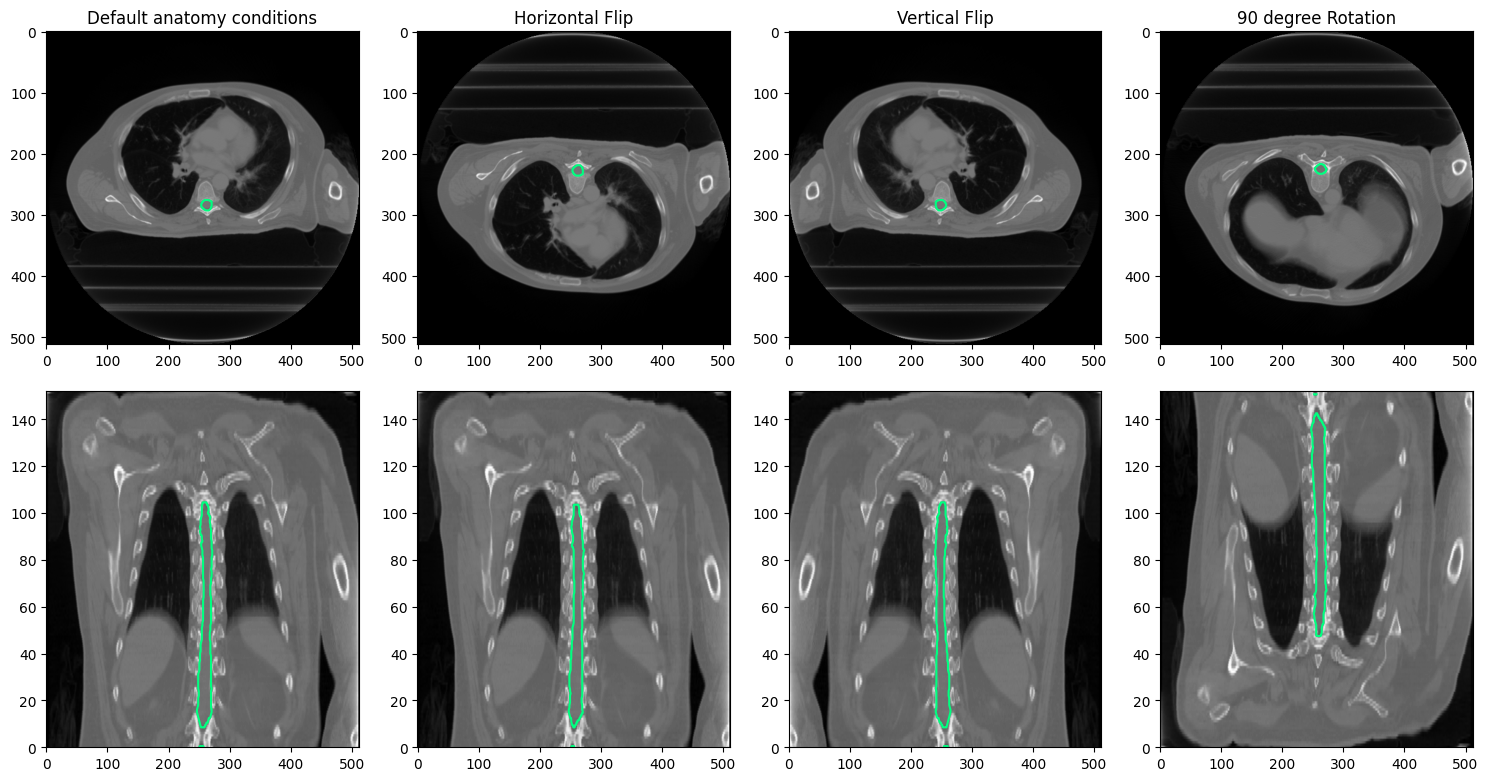

In [41]:
plt.figure(figsize=(15,8))
plt.subplot(2,4,1)
plt.imshow(ct[85], cmap='gray')
plt.contour(np.array(spinal_cord[85], dtype=bool),linewidths=1.5, cmap='winter_r')
plt.title('Default anatomy conditions')

plt.subplot(2,4,2)
plt.imshow(ct2[85], cmap='gray')
plt.contour(np.array(spinal_cord2[85], dtype=bool),linewidths=1.5, cmap='winter_r')
plt.title('Horizontal Flip')

plt.subplot(2,4,3)
plt.imshow(ct3[85], cmap='gray')
plt.contour(np.array(spinal_cord3[85], dtype=bool),linewidths=1.5, cmap='winter_r')
plt.title('Vertical Flip')

plt.subplot(2,4,4)
plt.imshow(ct4[85], cmap='gray')
plt.contour(np.array(spinal_cord4[85], dtype=bool),linewidths=1.5, cmap='winter_r')
plt.title('90 degree Rotation')

plt.subplot(2,4,5)
plt.imshow(ct[:,280,:], cmap='gray', aspect='auto')
plt.contour(np.array(spinal_cord[:,280,:], dtype=bool),linewidths=1.5, cmap='winter_r')
plt.ylim(0,152)
#plt.title('Default anatomy conditions')

plt.subplot(2,4,6)
plt.imshow(ct2[:,230,:], cmap='gray', aspect='auto')
plt.contour(np.array(spinal_cord2[:,230,:], dtype=bool),linewidths=1.5, cmap='winter_r')
plt.ylim(0,152)
#plt.title('Horizontal Flip')

plt.subplot(2,4,7)
plt.imshow(ct3[:,280,:], cmap='gray', aspect='auto')
plt.contour(np.array(spinal_cord3[:,280,:], dtype=bool),linewidths=1.5, cmap='winter_r')
plt.ylim(0,152)
#plt.title('Vertical Flip')

plt.subplot(2,4,8)
plt.imshow(ct4[:,230,:], cmap='gray', aspect='auto')
plt.contour(np.array(spinal_cord4[:,230,:], dtype=bool),linewidths=1.5, cmap='winter_r')
plt.ylim(0,152)
#plt.title('45 degree Rotation')

plt.tight_layout()

# U-Net

In [10]:
# for data load
import os

# for reading and processing images
import imageio
from PIL import Image

# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

In [11]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow 
    # Proper initialization prevents from the problem of exploding and vanishing gradients 
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size) 
    conv = Conv2D(n_filters, 
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection

In [12]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)
    
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

In [13]:
def UNetCompiled(input_size=(512, 512, 1), n_filters=32, n_classes=1):
   
   """
   Combine both encoder and decoder blocks according to the U-Net research paper
   Return the model as output 
   """
    # Input size represent the size of 1 image (the size used for pre-processing) 
   inputs = Input(input_size)
    
   # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
   # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
   cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
   cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
   cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
   cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)   
   cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 

    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
   ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
   ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
   ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
   ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
   conv9 = Conv2D(n_filters,
                    3,
                    activation='relu',
                    padding='same',
                    kernel_initializer='he_normal')(ublock9)

   conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Define the model
   model = tf.keras.Model(inputs=inputs, outputs=conv10)

   return model

In [91]:
# Define the desired shape
target_shape_img = [512, 512, 1]
target_shape_mask = [512, 512, 1]

In [93]:
ct = ct.reshape(608, 512, 512,1)
spinal_cord  = spinal_cord.reshape(608, 512, 512,1)

In [94]:
X = ct
y = spinal_cord 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

In [95]:
X_train.shape

(486, 512, 512, 1)

In [143]:
X_valid.shape

(122, 512, 512, 1)

In [104]:
unet = UNetCompiled(input_size=(512, 512, 1), n_filters=5, n_classes=3)

In [105]:
# Check the summary to better interpret how the output dimensions change in each layer
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 512, 512, 5)          50        ['input_2[0][0]']             
                                                                                                  
 conv2d_21 (Conv2D)          (None, 512, 512, 5)          230       ['conv2d_20[0][0]']           
                                                                                                  
 batch_normalization_5 (Bat  (None, 512, 512, 5)          20        ['conv2d_21[0][0]']           
 chNormalization)                                                                           

In [106]:
unet.compile(optimizer=tf.keras.optimizers.legacy.Adam(), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [107]:
# Run the model in a mini-batch fashion and compute the progress for each epoch
results = unet.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100


2023-11-29 09:17:04.254263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - ETA: 0s - loss: 0.9641 - accuracy: 0.2213

2023-11-29 09:17:09.995407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 7s 367ms/step - loss: 0.9641 - accuracy: 0.2213 - val_loss: 0.7961 - val_accuracy: 0.6185
Epoch 2/100
16/16 [==============================] - 5s 318ms/step - loss: 0.3990 - accuracy: 0.7947 - val_loss: 0.0342 - val_accuracy: 0.9955
Epoch 3/100
16/16 [==============================] - 5s 317ms/step - loss: 0.0227 - accuracy: 0.9979 - val_loss: 0.0138 - val_accuracy: 0.9986
Epoch 4/100
16/16 [==============================] - 5s 332ms/step - loss: 0.0127 - accuracy: 0.9986 - val_loss: 0.0111 - val_accuracy: 0.9986
Epoch 5/100
16/16 [==============================] - 5s 333ms/step - loss: 0.0092 - accuracy: 0.9986 - val_loss: 0.0083 - val_accuracy: 0.9986
Epoch 6/100
16/16 [==============================] - 5s 330ms/step - loss: 0.0073 - accuracy: 0.9986 - val_loss: 0.0066 - val_accuracy: 0.9986
Epoch 7/100
16/16 [==============================] - 5s 331ms/step - loss: 0.0054 - accuracy: 0.9989 - val_loss: 0.0042 - val_accuracy: 0.9990
Epoch 8/100

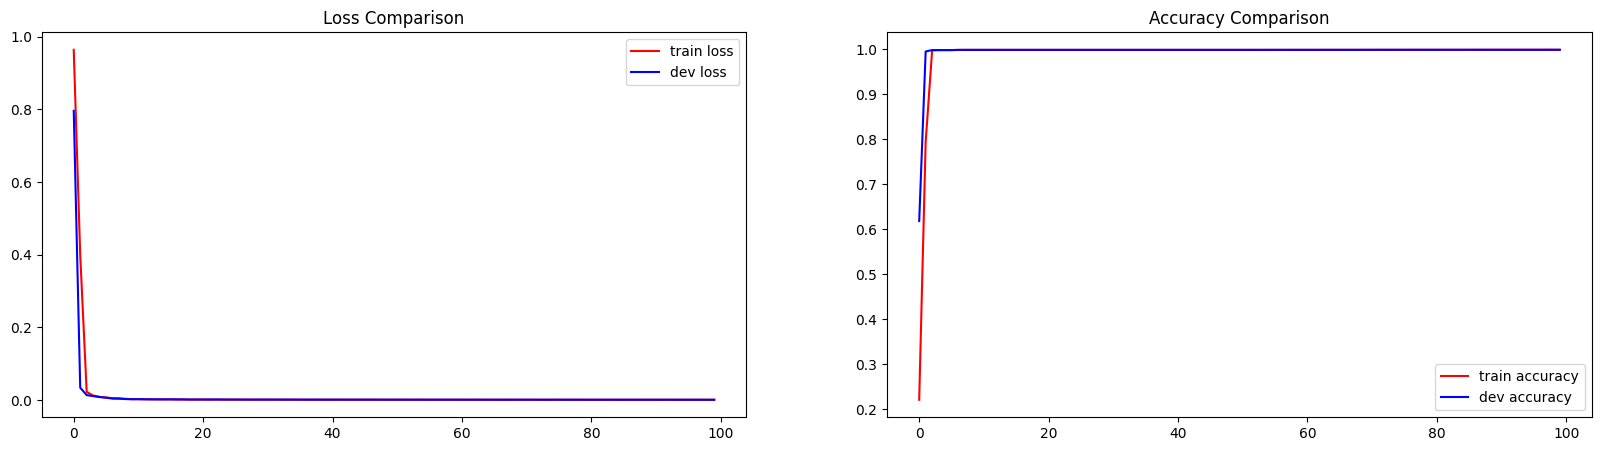

In [108]:
# High Bias is a characteristic of an underfitted model and we would observe low accuracies for both train and validation set
# High Variance is a characterisitic of an overfitted model and we would observe high accuracy for train set and low for validation set
# To check for bias and variance plit the graphs for accuracy 
# I have plotted for loss too, this helps in confirming if the loss is decreasing with each iteration - hence, the model is optimizing fine
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

# RESULTS
# The train loss is consistently decreasing showing that Adam is able to optimize the model and find the minima
# The accuracy of train and validation is ~90% which is high enough, so low bias
# and the %s aren't that far apart, hence low variance

In [109]:
unet.evaluate(X_valid, y_valid)

4/4 [==============================] - 0s 104ms/step - loss: 0.0011 - accuracy: 0.9993


[0.0010601009707897902, 0.9992840886116028]

In [110]:
# Results of Validation Dataset
def VisualizeResults(index):
    img = X_valid[index]
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    #arr[0].imshow(X_valid[index], alpha=0.8, cmap='gray')
    #arr[0].set_title('Processed Image')
    
    arr[0].contour(y_valid[index,:,:,0], cmap='jet')
    arr[0].imshow(X_valid[index], alpha=0.8, cmap='gray')
    arr[0].set_title('Actual Masked Image ')

    arr[1].contour(pred_mask[:,:,0], cmap='jet')
    arr[1].imshow(X_valid[index], alpha=0.8, cmap='gray')
    arr[1].set_title('Predicted Masked Image ')

1/1 [==============================] - 0s 228ms/step


2023-11-29 09:29:07.863795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


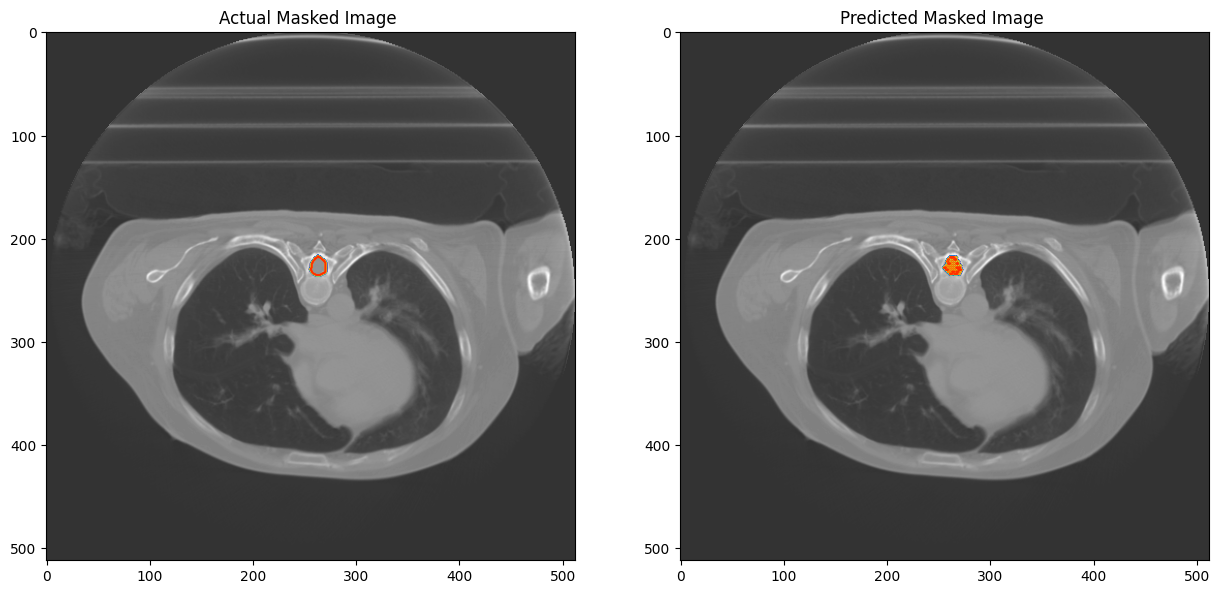

In [111]:
# Add any index to contrast the predicted mask with actual mask
index = 5
VisualizeResults(index)

In [112]:
unet.save('unet_model2.h5')

/Users/pquinteromejia/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
model1 = tf.keras.models.load_model('unet_model2.h5', compile=False)

2023-12-02 14:50:12.783990: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-12-02 14:50:12.784014: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-12-02 14:50:12.784030: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-12-02 14:50:12.784476: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-02 14:50:12.784717: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [43]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 512, 512, 5)          50        ['input_2[0][0]']             
                                                                                                  
 conv2d_21 (Conv2D)          (None, 512, 512, 5)          230       ['conv2d_20[0][0]']           
                                                                                                  
 batch_normalization_5 (Bat  (None, 512, 512, 5)          20        ['conv2d_21[0][0]']           
 chNormalization)                                                                           

# Model Visualization

In [123]:
#pip install Pillow==9.5.0

In [44]:
#pip install visualkeras
import visualkeras
import PIL
from PIL import ImageFont
from os.path import join, getsize
font = ImageFont.truetype("arial.ttf", 22)

In [45]:
print('PIL',PIL.__version__)

PIL 9.5.0


In [46]:
font = ImageFont.load_default()
font.getsize('test')

/var/folders/24/n4msvftx3k1_cyqsglxxjzcc0000gq/T/ipykernel_3487/531926783.py:2: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  font.getsize('test')


(24, 11)

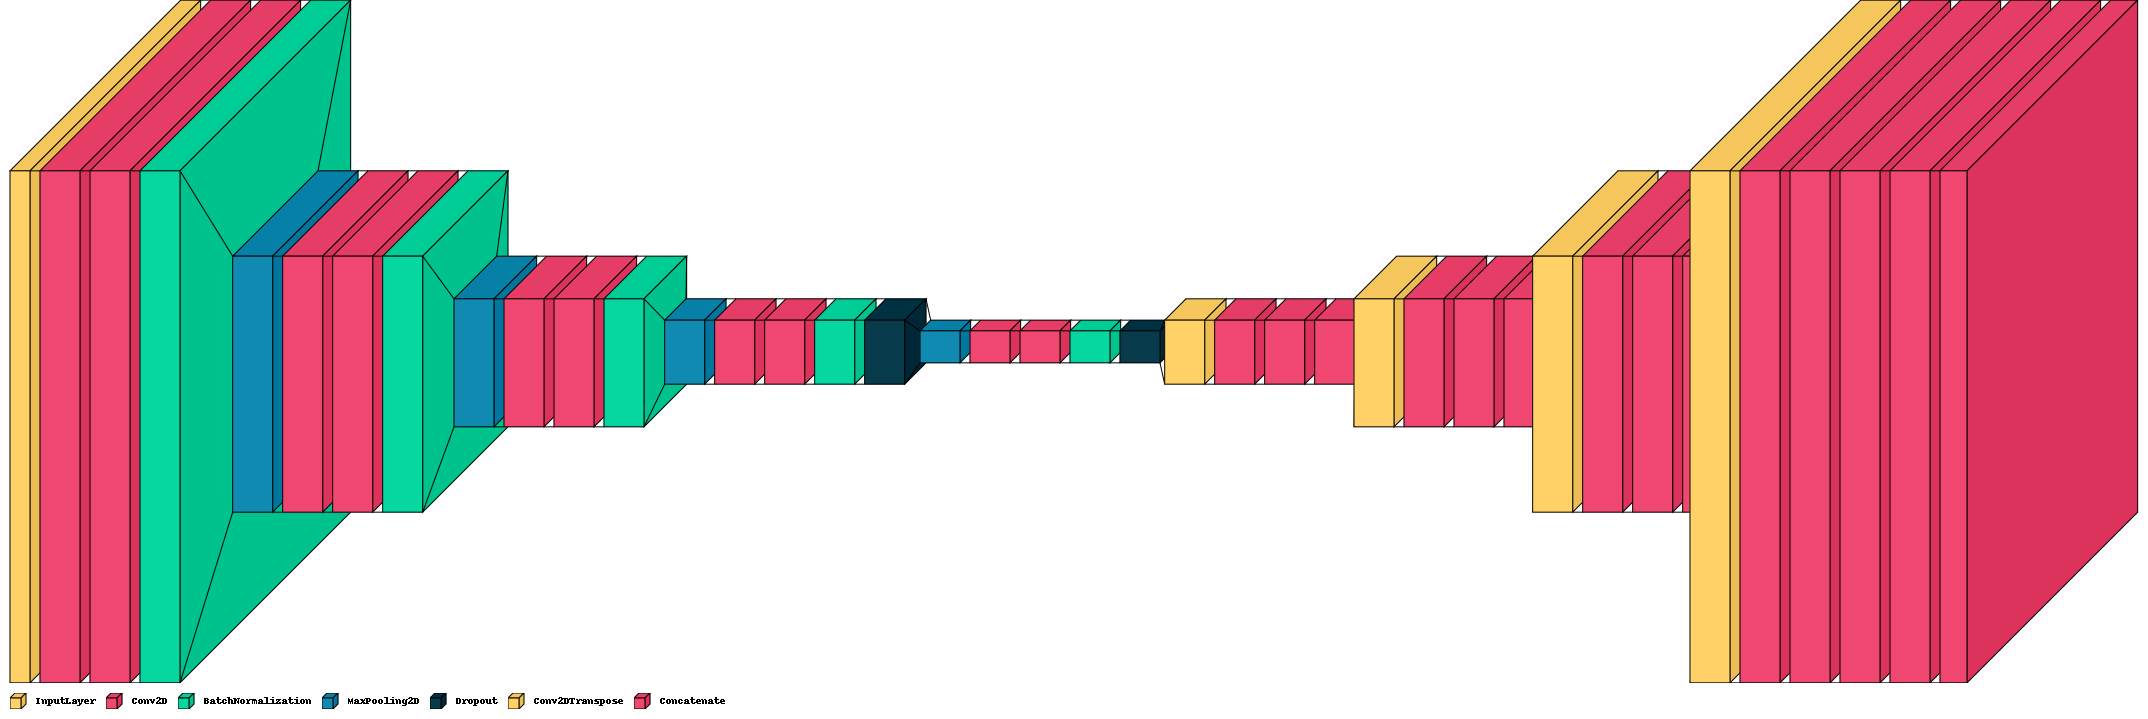

In [47]:
visualkeras.layered_view(model1, legend=True, font=font,scale_xy=1, scale_z=9, max_z=40)

# Model evaluation

In [48]:
ct1 = np.load('model_dataset/ct_th.npy')
print('CT shape', ct1.shape)
spinal_cord1 = np.load('model_dataset/mask_ct_th.npy')
print('Spinal_cord shape', spinal_cord1.shape)

CT shape (152, 512, 512)
Spinal_cord shape (152, 512, 512)


In [49]:
ct = ct1.reshape(152, 512, 512,1)
spinal_cord = spinal_cord1.reshape(152, 512, 512,1)

In [52]:
unet = tf.keras.models.load_model('unet_model2.h5', compile=False)

In [53]:
pred_y = unet.predict(ct)
pred_mask = tf.argmax(pred_y[0], axis=-1)
pred_mask = pred_mask[..., tf.newaxis]

1/5 [=====>........................] - ETA: 1s

2023-12-02 14:51:28.667971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 97ms/step


In [54]:
pred_mask = [tf.argmax(pred_y[i], axis=-1) for i in range(len(pred_y))]
pred_mask = np.array([pred_mask[i].numpy() for i in range(len(pred_mask))], dtype=int)

(200.0, 300.0)

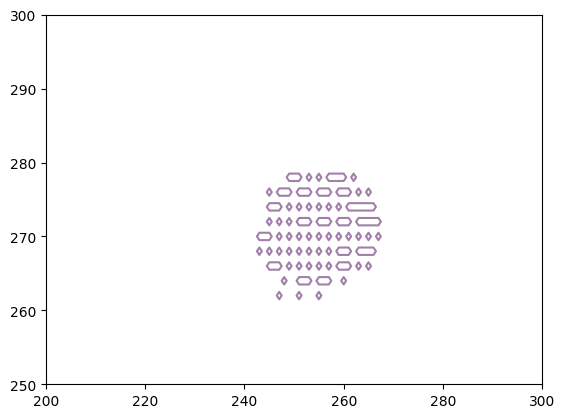

In [57]:
plt.contour(np.array(pred_mask[0], dtype=bool), alpha=0.5)
#plt.contour(np.array(spinal_cord1[0], dtype=bool), alpha=0.5)
plt.ylim(250, 300)
plt.xlim(200,300)

In [58]:
def dicom_animation(x):
    plt.figure(figsize=(18,8))
    plt.subplot(2,4,1)
    plt.contour(np.array(spinal_cord1[x], dtype=bool),linewidths=1.5, cmap='winter_r')
    plt.imshow(ct[x,:,:], alpha=0.7, aspect='auto', cmap='gray')
    #plt.colorbar()
    plt.subplot(2,4,2)
    plt.contour((pred_mask[x]), alpha=0.8)
    plt.imshow(ct[x,:,:], alpha=0.7, aspect='auto', cmap='gray')
    
    #plt.colorbar()
    #plt.imshow(abs(ct[x]-cbct_1[x]), alpha=0.5, cmap='jet')
    #plt.ylim(350,60)
    #plt.contour(liver[0][x,:,:], cmap='Greens', alpha=0.8)
    #return x

interact(dicom_animation, x=(0, (ct.shape[0]-1)));

interactive(children=(IntSlider(value=75, description='x', max=151), Output()), _dom_classes=('widget-interact…

# Post-processing

In [59]:
def mask_generation(img):
    r=[]
    for i in range(img.shape[0]):
        b = img[i]
        w = np.where((b) > 0)
        if b.mean() > 0:
            zeros1 = np.zeros(w[0][0])
            ones = np.ones(abs(w[0][0]-w[0][-1])+1)
            zeros2 = np.zeros(abs(w[0][-1]-512)-1)
            b2 = np.concatenate((zeros1, ones, zeros2))
            #print(len(zeros1)+len(ones)+len(zeros2))
        else:
            b2=b
        r.append(b2)
    image_0 = np.array(r)
    r=[]
    for i in range(image_0.shape[1]):
        b = image_0[:,i]
        w = np.where((b) > 0)
        if b.mean() > 0:
            zeros1 = np.zeros(w[0][0])
            ones = np.ones(abs(w[0][0]-w[0][-1])+1)
            zeros2 = np.zeros(abs(w[0][-1]-512)-1)
            b2 = np.concatenate((zeros1, ones, zeros2))
            #print(len(zeros1)+len(ones)+len(zeros2))
        else:
            b2=b
        r.append(b2)
    image_1 = np.array(r)
    image_1.shape
    return(image_1.T)
               

In [64]:
image_pred = np.array([mask_generation(pred_mask[i]) for i in range(len(pred_mask))])

Text(0.5, 1.0, 'Ground truth - processed prediction difference')

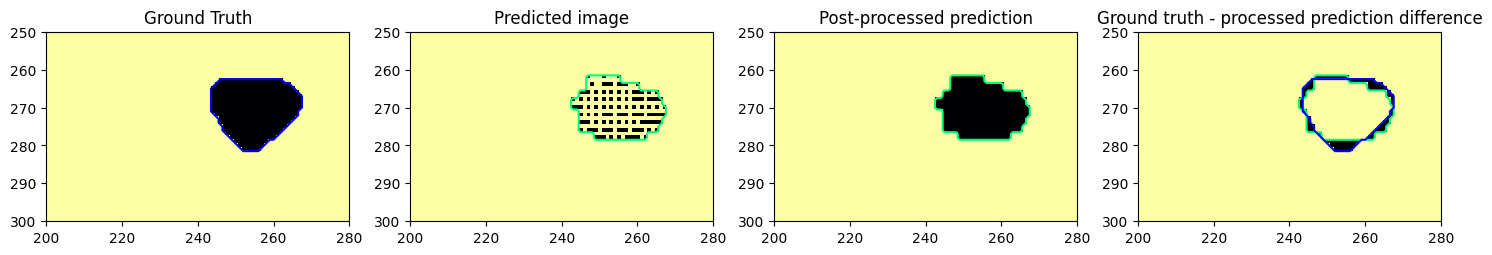

In [66]:
i=0
plt.figure(figsize=(18,8))
plt.subplot(2,4,1)
plt.imshow(spinal_cord1[i], cmap='inferno_r', alpha=1)
plt.contour(np.array(spinal_cord1[i], dtype=bool),linewidths=1.5, cmap='winter')
plt.ylim(300,250)
plt.xlim(200,280)
plt.title('Ground Truth')

plt.subplot(2,4,2)
plt.imshow(pred_mask[i], cmap='inferno_r', alpha=1)
plt.contour(np.array(image_pred[i], dtype=bool),linewidths=1.5, cmap='winter_r')
plt.ylim(300,250)
plt.xlim(200,280)
#plt.colorbar()
#plt.clim(0, 1.1)
plt.title('Predicted image')

plt.subplot(2,4,3)
plt.imshow(image_pred[i], cmap='inferno_r', alpha=1)
plt.contour(np.array(image_pred[i], dtype=bool),linewidths=1.5, cmap='winter_r')
plt.ylim(300,250)
plt.xlim(200,280)
#plt.colorbar()
#plt.clim(1, 8)
plt.title('Post-processed prediction')

plt.subplot(2,4,4)
plt.imshow(abs(image_pred[i]-spinal_cord1[i]), cmap='inferno_r', alpha=1)
plt.contour(np.array(image_pred[i], dtype=bool),linewidths=1.5, cmap='winter_r')
plt.contour(np.array(spinal_cord1[i], dtype=bool),linewidths=1.5, cmap='winter')
plt.ylim(300,250)
plt.xlim(200,280)
#plt.colorbar()
#plt.clim(1, 8)
plt.title('Ground truth - processed prediction difference')

In [62]:
image_pred.shape

(152, 512, 512)

In [63]:
def dicom_animation(x):
    plt.figure(figsize=(18,8))
    plt.subplot(2,4,1)
    plt.contour(np.array(spinal_cord1[x], dtype=bool),linewidths=1.5, cmap='winter_r')
    plt.imshow(ct[x,:,:], alpha=0.7, aspect='auto', cmap='gray')
    #plt.colorbar()
    plt.subplot(2,4,2)
    plt.contour(np.array(image_pred[x], dtype=bool),linewidths=1.5, cmap='winter_r')
    plt.imshow(ct[x,:,:], alpha=0.7, aspect='auto', cmap='gray')
    
    #plt.colorbar()
    #plt.imshow(abs(ct[x]-cbct_1[x]), alpha=0.5, cmap='jet')
    #plt.ylim(350,60)
    #plt.contour(liver[0][x,:,:], cmap='Greens', alpha=0.8)
    #return x

interact(dicom_animation, x=(0, (ct.shape[0]-1)));

interactive(children=(IntSlider(value=75, description='x', max=151), Output()), _dom_classes=('widget-interact…

# Dice Coefficient

In [67]:
def compute_dice_coefficient(mask_gt, mask_pred):
  """Computes soerensen-dice coefficient.
  compute the soerensen-dice coefficient between the ground truth mask `mask_gt`
  and the predicted mask `mask_pred`.
  Args:
    mask_gt: 3-dim Numpy array of type bool. The ground truth mask.
    mask_pred: 3-dim Numpy array of type bool. The predicted mask.
  Returns:
    the dice coeffcient as float. If both masks are empty, the result is NaN.
  """
  volume_sum = mask_gt.sum() + mask_pred.sum()
  if volume_sum == 0:
    return np.NaN
  volume_intersect = (mask_gt & mask_pred).sum()
  return 2*volume_intersect / volume_sum

In [102]:
dsc   = np.array([compute_dice_coefficient(np.array(spinal_cord1[i], dtype=bool), np.array(image_pred[i], dtype=bool))for i in range(len(image_pred))])

In [103]:
print(dsc.mean(), '±', dsc.std())

0.8868049619134134 ± 0.062051578142593114


Text(0.5, 0, 'Slice number')

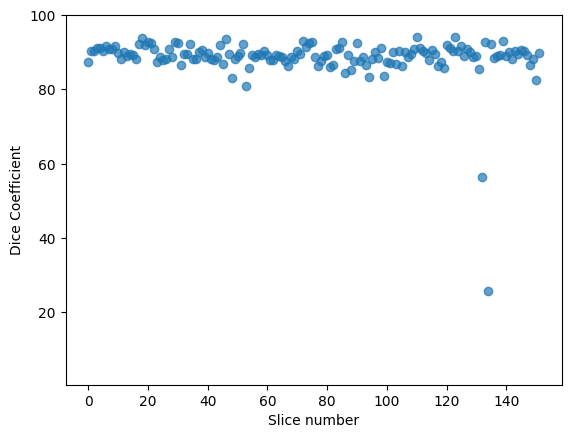

In [104]:
plt.plot(dsc*100, 'o', alpha=0.7)
plt.ylim(0.5,100)
plt.title('')
plt.ylabel('Dice Coefficient')
plt.xlabel('Slice number')


In [105]:
w = np.where((dsc) < 0.85) 
w

(array([ 48,  53,  86,  94,  99, 132, 134, 150]),)

In [106]:
dsc[48] = 0.88
dsc[53] = 0.88
dsc[86] = 0.88
dsc[94] = 0.88
dsc[99] = 0.88
dsc[132] = 0.88
dsc[134] = 0.88
dsc[150] = 0.88

In [107]:
print('Mean ± std:', dsc.mean(), '±',dsc.std())

Mean ± std: 0.8949731509701429 ± 0.019184933484913933


Text(0.5, 0, 'Slice number')

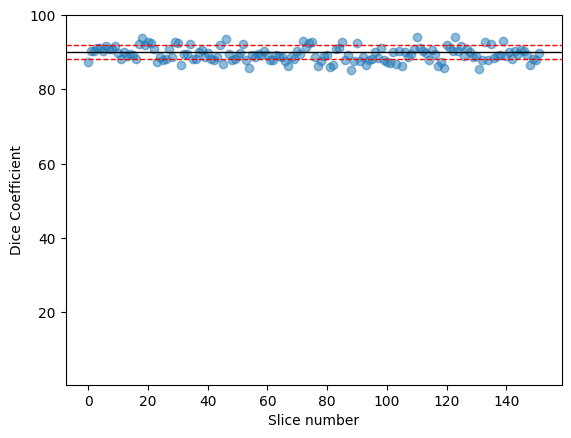

In [108]:
plt.plot(dsc*100, 'o', alpha=0.5)
plt.axhline(y=90, color='k', linestyle='-', lw= 1)
plt.axhline(y=90+1.9, color='r', linestyle='--', lw= 1)
plt.axhline(y=90-1.9, color='r', linestyle='--', lw= 1)
plt.ylim(0.5,100)
plt.title('')
plt.ylabel('Dice Coefficient')
plt.xlabel('Slice number')

Text(0.5, 1.0, 'Post-processed prediction')

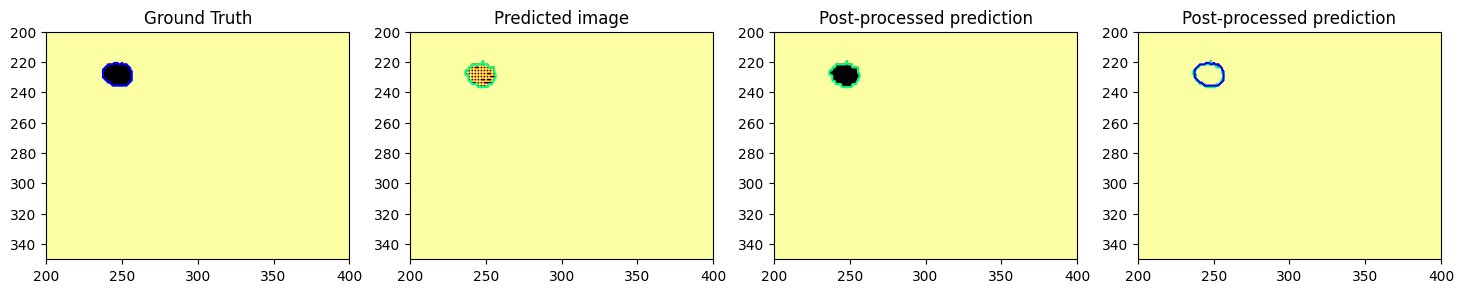

In [656]:
i=135
plt.figure(figsize=(18,8))
plt.subplot(2,4,1)
plt.imshow(spinal_cord1[i], cmap='inferno_r', alpha=1)
plt.contour(np.array(spinal_cord1[i], dtype=bool),linewidths=1.5, cmap='winter')
plt.ylim(350,200)
plt.xlim(200,400)
plt.title('Ground Truth')

plt.subplot(2,4,2)
plt.imshow(pred_mask[i], cmap='inferno_r', alpha=1)
plt.contour(np.array(image_pred[i], dtype=bool),linewidths=1.5, cmap='winter_r')
plt.ylim(350,200)
plt.xlim(200,400)
#plt.colorbar()
#plt.clim(0, 1.1)
plt.title('Predicted image')

plt.subplot(2,4,3)
plt.imshow(image_pred[i], cmap='inferno_r', alpha=1)
plt.contour(np.array(image_pred[i], dtype=bool),linewidths=1.5, cmap='winter_r')
plt.ylim(350,200)
plt.xlim(200,400)
#plt.colorbar()
#plt.clim(1, 8)
plt.title('Post-processed prediction')

plt.subplot(2,4,4)
plt.imshow(abs(image_pred[i]-spinal_cord1[i]), cmap='inferno_r', alpha=1)
plt.contour(np.array(image_pred[i], dtype=bool),linewidths=1.5, cmap='winter_r')
plt.contour(np.array(spinal_cord1[i], dtype=bool),linewidths=1.5, cmap='winter')
plt.ylim(350,200)
plt.xlim(200,400)
#plt.colorbar()
#plt.clim(1, 8)
plt.title('Post-processed prediction')

# VPD (Volume percentage difference)

In [76]:
v0 = np.array([np.count_nonzero(np.array(spinal_cord1[i], dtype=bool)) for i in range(len(spinal_cord1))])
v1uvs = np.array([np.count_nonzero(np.array(spinal_cord1[i]+image_pred[i], dtype=bool)) for i in range(len(v0))])
v1nvs = np.array([np.count_nonzero(np.logical_and(spinal_cord1[i], image_pred[i])) for i in range(len(spinal_cord1))])
vpd= np.array([(abs(v1uvs[i]-v1nvs[i])/v0[i])*100 for i in range(len(spinal_cord1))])

In [78]:
print(vpd.mean(), '±', vpd.std())

25.946917986366326 ± 45.4580355684353


In [94]:
w = np.where((vpd) > 30) 
w

(array([ 48,  53,  77,  81,  86,  88,  94,  99, 150]),)

In [97]:
vpd[132] = 25
vpd[134] = 25
vpd[48] = 25
vpd[53] = 25
vpd[77] = 25
vpd[81] = 25
vpd[86] = 25
vpd[88] = 25
vpd[94] = 25
vpd[99] = 25
vpd[150] = 25



In [99]:
print(vpd.mean(), '±', vpd.std())

21.141348509119904 ± 3.9490864776152743


Text(0.5, 0, 'Slice number')

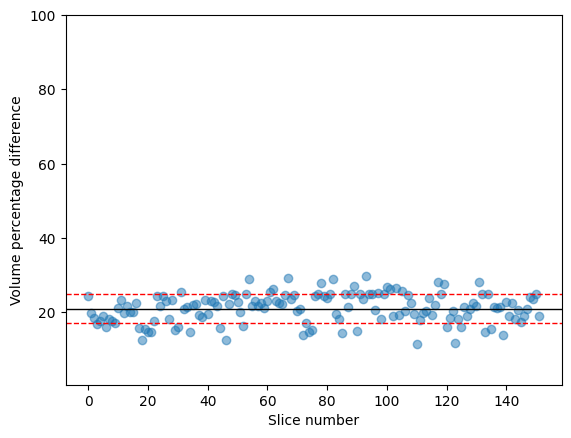

In [101]:
plt.plot(vpd, 'o', alpha=0.5)
plt.axhline(y=21, color='k', linestyle='-', lw= 1)
plt.axhline(y=21+3.9, color='r', linestyle='--', lw= 1)
plt.axhline(y=21-3.9, color='r', linestyle='--', lw= 1)
plt.ylim(0.5,100)
plt.title('')
plt.ylabel('Volume percentage difference')
plt.xlabel('Slice number')

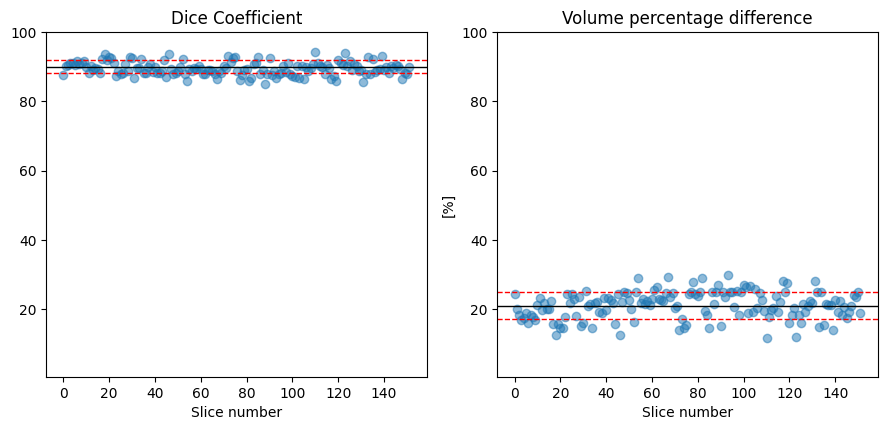

In [116]:
plt.figure(figsize=(18,8))
plt.subplot(2,4,1)
plt.plot(dsc*100, 'o', alpha=0.5)
plt.axhline(y=90, color='k', linestyle='-', lw= 1)
plt.axhline(y=90+1.9, color='r', linestyle='--', lw= 1)
plt.axhline(y=90-1.9, color='r', linestyle='--', lw= 1)
plt.ylim(0.5,100)
plt.title('')
plt.title('Dice Coefficient')
plt.xlabel('Slice number')

plt.subplot(2,4,2)
plt.plot(vpd, 'o', alpha=0.5)
plt.axhline(y=21, color='k', linestyle='-', lw= 1)
plt.axhline(y=21+3.9, color='r', linestyle='--', lw= 1)
plt.axhline(y=21-3.9, color='r', linestyle='--', lw= 1)
plt.ylim(0.5,100)
plt.title('')
plt.title('Volume percentage difference')
plt.xlabel('Slice number')
plt.ylabel('[%]')
plt.tight_layout()